In [29]:
import psycopg2

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

from pprint import pprint
from collections import OrderedDict

from clickhouse_driver import Client

client = Client('localhost', database="thesisnumclientsdb")

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)
print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

16
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_2clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_3clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_4clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_5clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_6clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_dtls_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_dtls_https_2clients_noattacker__140sec_proxy__30sec_attacker__1

,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,1,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
1,thesis_group_num_clients_coap_https_2clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,2,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
2,thesis_group_num_clients_coap_https_3clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,3,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
3,thesis_group_num_clients_coap_https_4clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,4,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
4,thesis_group_num_clients_coap_https_5clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,5,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
5,thesis_group_num_clients_coap_https_6clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,6,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
6,thesis_group_num_clients_coap_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,7,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
7,thesis_group_num_clients_coap_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
8,thesis_group_num_clients_dtls_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,1,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
9,thesis_group_num_clients_dtls_https_2clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,2,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False


In [3]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 122, 123, 124, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 163, 164, 165, 170, 171, 172, 173, 174, 175, 176, 177, 182, 183, 184, 185, 186, 187, 188, 189}
attacker_dnids={1, 97, 121, 37, 133, 73, 169, 13, 109, 49, 145, 85, 157, 181, 25, 61}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
CPU times: user 6.66 ms, sys: 0 ns, total: 6.66 ms
Wall time: 24.5 ms


In [4]:
%%time

client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' '' 'bad_gateway']
CPU times: user 4.36 s, sys: 2.23 s, total: 6.59 s
Wall time: 31.3 s


,exp_id,trial,observer_id,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,client1,1,content,0.000000,0.340071,0.000000,0.000000,0.340071,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
1,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,client1,2,content,0.355290,0.415595,0.355290,0.355290,0.415595,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
2,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,client1,3,content,0.418002,0.477663,0.418002,0.418002,0.477663,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
3,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,client1,4,content,0.479755,0.536881,0.479755,0.479755,0.536881,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
4,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,client1,5,content,0.539208,0.595318,0.539208,0.539208,0.595318,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797570,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client8,17773,content,125.717236,125.769829,125.717236,125.717236,125.769829,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
797571,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client8,17774,content,125.770620,125.823153,125.770620,125.770620,125.823153,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
797572,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client8,17775,content,125.823910,125.876400,125.823910,125.823910,125.876400,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
797573,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client8,17776,content,125.877252,125.929843,125.877252,125.877252,125.929843,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False


In [5]:
%%time

(
  message_rtt_df.groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    avg_rtt_ms_first_transmission=("rtt_ms_first_transmission", "mean"),
    avg_rtt_ms_last_transmission=("rtt_ms_last_transmission", "mean"),
    num_unique_messages=("message_marker", "nunique"),
    num_messages=("message_marker", "count"),
    num_successful_messages=("successful_message", "sum"),
    num_send_messages=("num_send_observations", "sum"),
    num_recv_messages=("num_recv_observations", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
  )
)

CPU times: user 581 ms, sys: 9.84 ms, total: 591 ms
Wall time: 1.77 s


avg_rtt_ms_first_transmission  \
exp_id                                                                                               trial observer_id                                  
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 1     client1                          53.514646   
                                                                                                     2     client1                          53.478773   
                                                                                                     3     client1                          53.504021   
                                                                                                     4     client1                          53.486532   
                                                                                                     5     client1                          53.490108   
...                                                                                                                                               ...   
thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 5     client4                          52.611271   
                                                                                                           client5                          52.565499   
                                                                                                           client6                          52.572990   
                                                                                                           client7                          52.551917   
                                                                                                           client8                          52.524888   

                                                                                                                        avg_rtt_ms_last_transmission  \
exp_id                                                                                               trial observer_id                                 
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 1     client1                         53.514646   
                                                                                                     2     client1                         53.478773   
                                                                                                     3     client1                         53.504021   
                                                                                                     4     client1                         53.486532   
                                                                                                     5     client1                         53.490108   
...                                                                                                                                              ...   
thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 5     client4                         52.611271   
                                                                                                           client5                         52.565499   
                                                                                                           client6                         52.572990   
                                                                                                           client7                         52.551917   
                                                                                                           client8                         52.524888   

                                                                                                                        num_unique_messages  \
exp_id    

In [6]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 137 ms


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,0.935714,0.3,11.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
1,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,1.565000,0.5,21.2,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
2,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,261.662810,250.0,263.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
3,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,366.561983,251.0,404.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
4,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,2,originserver,cpu_utilization,0.927143,0.3,10.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,4,proxy,memory_utilization,462.127273,245.0,495.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
316,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,originserver,cpu_utilization,1.485714,0.4,9.2,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
317,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,proxy,cpu_utilization,3.462143,0.5,26.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
318,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,originserver,memory_utilization,260.966997,247.0,262.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False


In [26]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 2.81 s, sys: 101 ms, total: 2.91 s
Wall time: 2.91 s


,exp_id,trial,observer_id,num_messages,num_successful_messages,mean_rps,num_retransmissions,stddev_rtt_ms,min_rtt_ms,median_rtt_ms,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,client1,2193,2192,18.266667,0,6.225256,52.523136,53.233027,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,no-attacker
1,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,2,client1,2195,2194,18.283333,0,5.871298,52.347183,53.217888,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,no-attacker
2,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,3,client1,2194,2193,18.275000,0,6.452826,52.574158,53.226948,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,no-attacker
3,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,4,client1,2196,2195,18.291667,0,6.344324,52.577019,53.225040,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,no-attacker
4,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client1,2195,2194,18.283333,0,6.272037,52.393913,53.220510,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,no-attacker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client4,2211,2210,18.416667,0,1.313610,51.450014,52.492976,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,dtls,https,no-attacker
356,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client5,2219,2218,18.483333,0,0.544515,51.644802,52.495003,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,dtls,https,no-attacker
357,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client6,2219,2218,18.483333,0,0.817425,51.687956,52.504897,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,dtls,https,no-attacker
358,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,client7,2220,2220,18.500000,0,0.749001,51.648855,52.508831,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,dtls,https,no-attacker


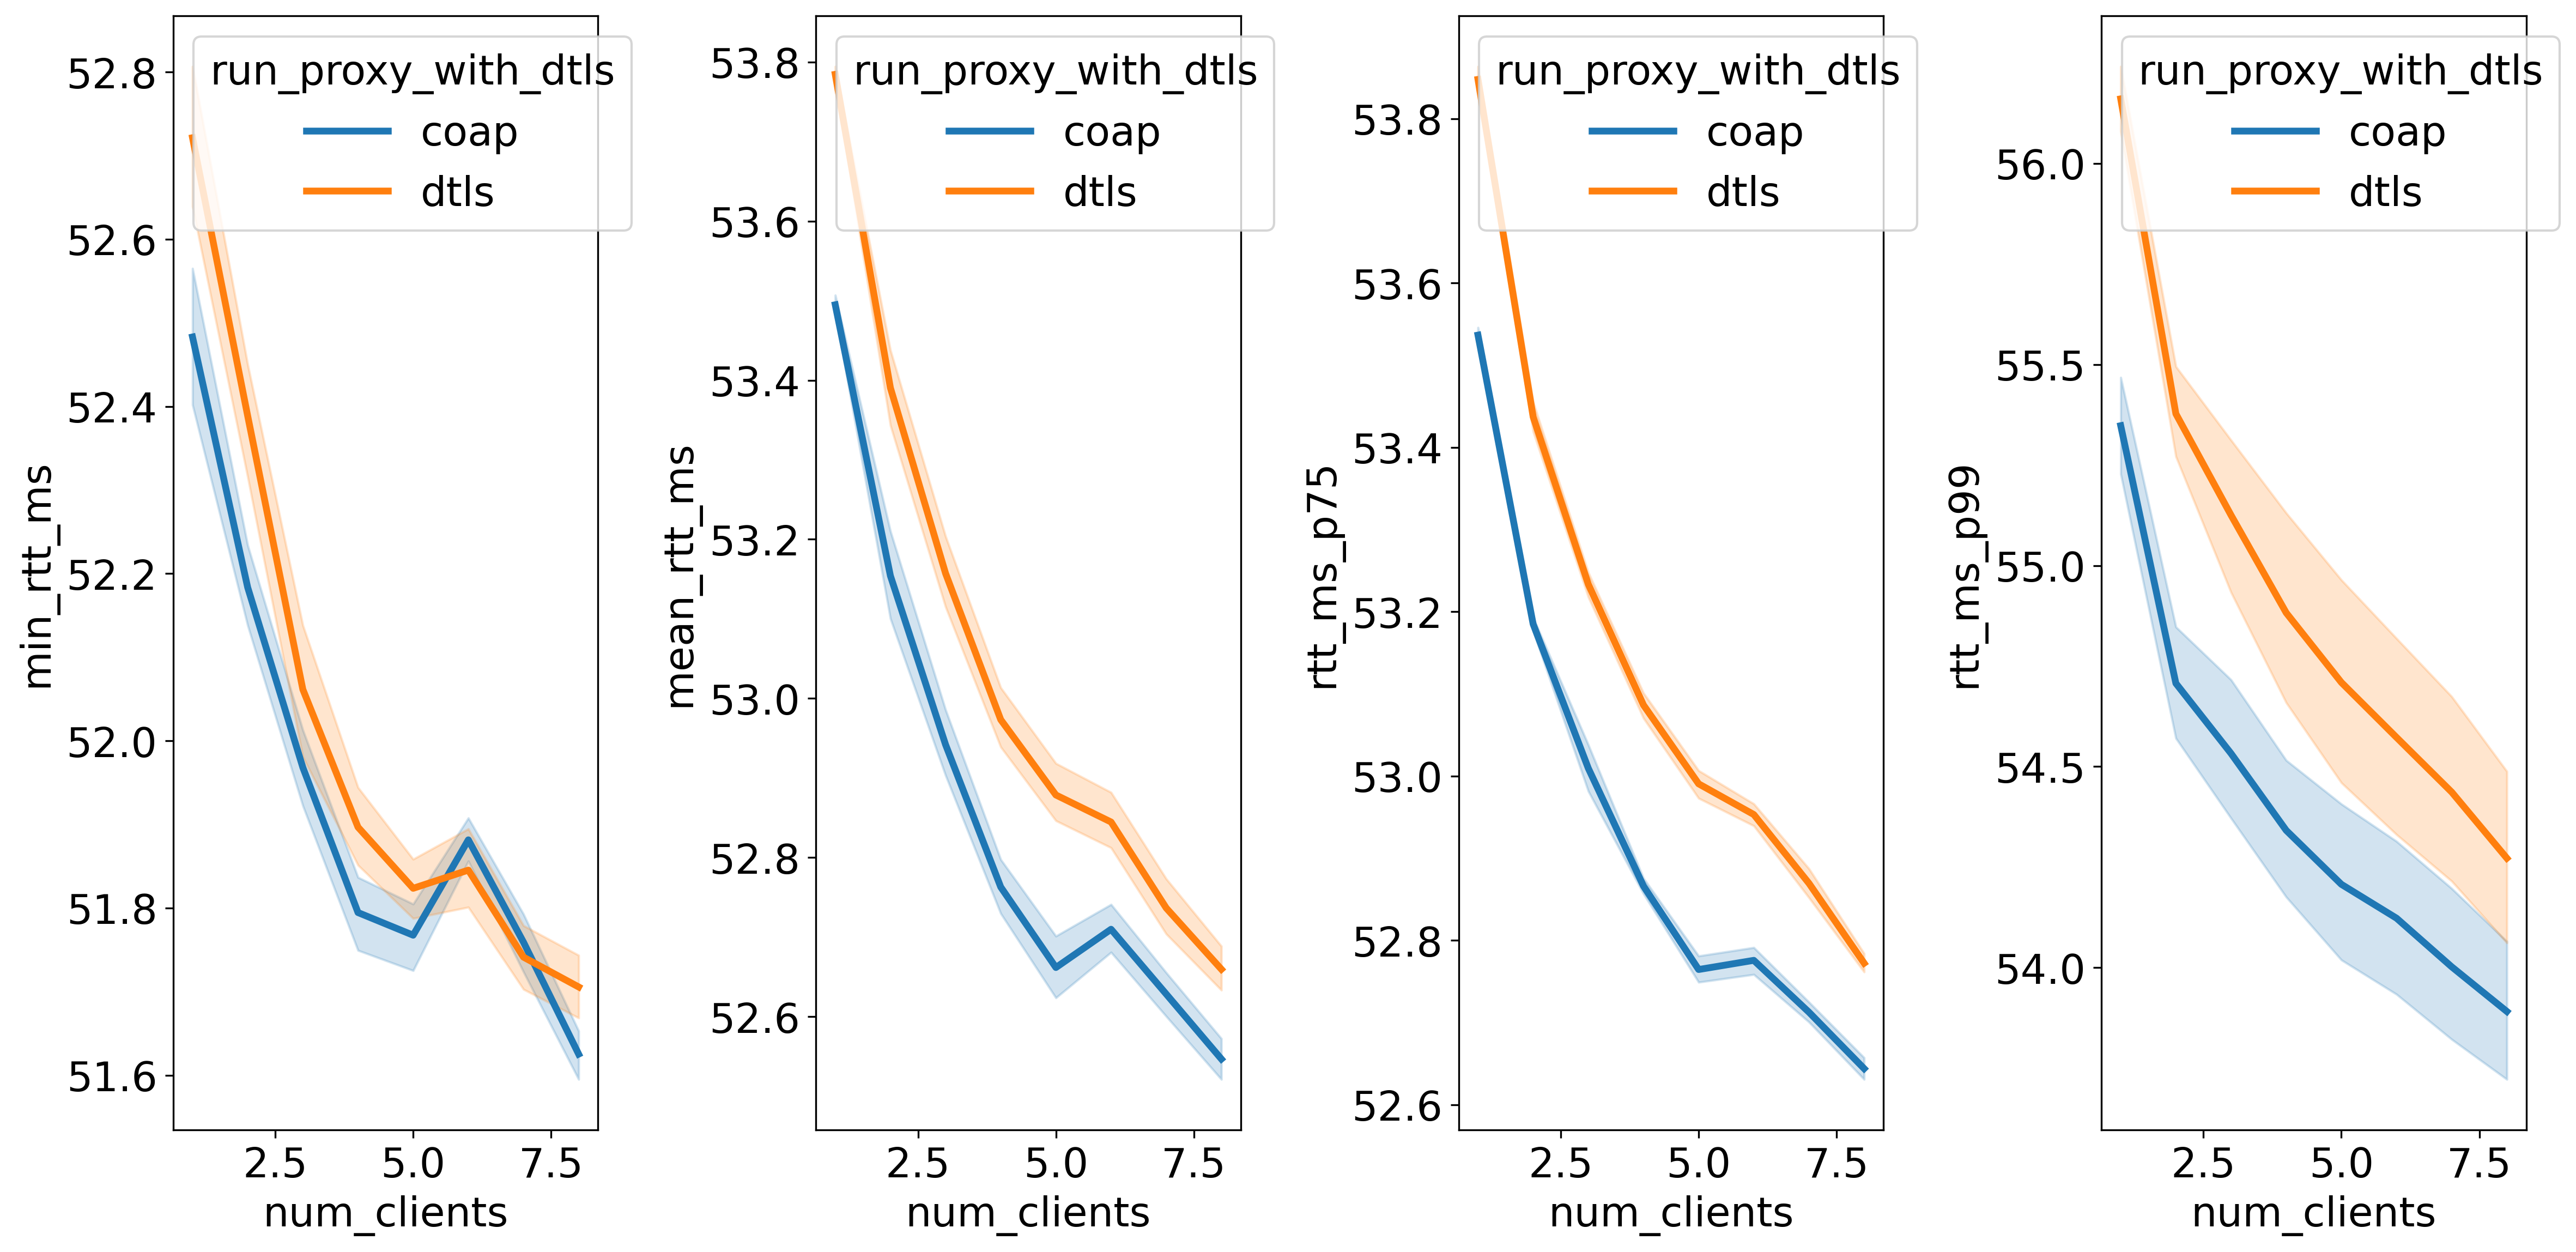

In [30]:
df = client_rps_df

ys = ["min_rtt_ms", "mean_rtt_ms", "rtt_ms_p75", "rtt_ms_p99"]
fig, ax = plt.subplots(1, len(ys))
for i, y in enumerate(ys):
  g = sns.lineplot(
    data=df,
    x="num_clients",
    y=y,
    hue="run_proxy_with_dtls",
    ax=ax[i]
  )

fig.tight_layout()
plt.show()

In [31]:
_df5 = pl.read_csv("/home/ubuntu/dos-californium/deter/expdata/real/final/thesis_group_num_clients_coap_https_5clients_noattacker__140sec_proxy__30sec_attacker__120sec_client/1/proxy_dump.pcap.connections.out", sep=";", quote_char='"')
_df6 = pl.read_csv("/home/ubuntu/dos-californium/deter/expdata/real/final/thesis_group_num_clients_coap_https_6clients_noattacker__140sec_proxy__30sec_attacker__120sec_client/1/proxy_dump.pcap.connections.out", sep=";", quote_char='"')

_cdf5 = _df5[
  (_df5["_ws.col.Protocol"] == "TCP")
  & (
    ((_df5["tcp.flags.syn"] == 1 ) & (_df5["tcp.srcport"] != 443 )) 
    | ((_df5["tcp.flags.fin"] == 1 ) & (_df5["tcp.srcport"] != 443 ))
  )
]
_cdf5["syn_sum"] = _cdf5["tcp.flags.syn"].cumsum()
_cdf5["fin_sum"] = _cdf5["tcp.flags.fin"].cumsum()
_cdf5["cumulative_egress_connections"] = _cdf5["syn_sum"] - _cdf5["fin_sum"]

_cdf6 = _df6[
  (_df6["_ws.col.Protocol"] == "TCP")
  & (
    ((_df6["tcp.flags.syn"] == 1 ) & (_df6["tcp.srcport"] != 443 )) 
    | ((_df6["tcp.flags.fin"] == 1 ) & (_df6["tcp.srcport"] != 443 ))
  )
]
_cdf6["syn_sum"] = _cdf6["tcp.flags.syn"].cumsum()
_cdf6["fin_sum"] = _cdf6["tcp.flags.fin"].cumsum()
_cdf6["cumulative_egress_connections"] = _cdf6["syn_sum"] - _cdf6["fin_sum"]

_cdf5

_ws.col.Time,_ws.col.Source,_ws.col.Destination,tcp.srcport,tcp.dstport,_ws.col.Length,_ws.col.Protocol,tcp.flags.syn,tcp.flags.fin,_ws.col.Info,syn_sum,fin_sum,cumulative_egress_connections
f64,str,str,i64,i64,i64,str,i64,i64,str,i64,i64,i64
0.052243,"""10.1.88.1""","""10.1.1.1""",40560,443,74,"""TCP""",1,0,"""40560 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3975892783 TSecr=0 WS=256""",1,0,1
2.080962,"""10.1.88.1""","""10.1.1.1""",40562,443,74,"""TCP""",1,0,"""40562 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3975894812 TSecr=0 WS=256""",2,0,2
3.149015,"""10.1.88.1""","""10.1.1.1""",40564,443,74,"""TCP""",1,0,"""40564 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3975895880 TSecr=0 WS=256""",3,0,3
4.160475,"""10.1.88.1""","""10.1.1.1""",40566,443,74,"""TCP""",1,0,"""40566 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3975896891 TSecr=0 WS=256""",4,0,4
4.318717,"""10.1.88.1""","""10.1.1.1""",40568,443,74,"""TCP""",1,0,"""40568 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3975897049 TSecr=0 WS=256""",5,0,5
124.48135,"""10.1.88.1""","""10.1.1.1""",40566,443,66,"""TCP""",0,1,"""40566 → 443 [FIN, ACK] Seq=364061 Ack=928374 Win=312320 Len=0 TSval=3976017210 TSecr=734770826""",5,1,4
125.585135,"""10.1.88.1""","""10.1.1.1""",40562,443,66,"""TCP""",0,1,"""40562 → 443 [FIN, ACK] Seq=367167 Ack=936449 Win=312320 Len=0 TSval=3976018314 TSecr=734771934""",5,2,3
126.589447,"""10.1.88.1""","""10.1.1.1""",40564,443,66,"""TCP""",0,1,"""40564 → 443 [FIN, ACK] Seq=371699 Ack=947924 Win=312320 Len=0 TSval=3976019319 TSecr=734772939""",5,3,2
127.65279,"""10.1.88.1""","""10.1.1.1""",40560,443,66,"""TCP""",0,1,"""40560 → 443 [FIN, ACK] Seq=389738 Ack=995928 Win=64256 Len=0 TSval=3976020382 TSecr=734774002""",5,4,1


In [32]:
_cdf6

_ws.col.Time,_ws.col.Source,_ws.col.Destination,tcp.srcport,tcp.dstport,_ws.col.Length,_ws.col.Protocol,tcp.flags.syn,tcp.flags.fin,_ws.col.Info,syn_sum,fin_sum,cumulative_egress_connections
f64,str,str,i64,i64,i64,str,i64,i64,str,i64,i64,i64
0.054046,"""10.1.88.1""","""10.1.1.1""",49264,443,74,"""TCP""",1,0,"""49264 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3890225579 TSecr=0 WS=256""",1,0,1
0.961427,"""10.1.88.1""","""10.1.1.1""",49266,443,74,"""TCP""",1,0,"""49266 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3890226486 TSecr=0 WS=256""",2,0,2
1.996059,"""10.1.88.1""","""10.1.1.1""",49268,443,74,"""TCP""",1,0,"""49268 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3890227521 TSecr=0 WS=256""",3,0,3
3.060682,"""10.1.88.1""","""10.1.1.1""",49270,443,74,"""TCP""",1,0,"""49270 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3890228586 TSecr=0 WS=256""",4,0,4
8.262039,"""10.1.88.1""","""10.1.1.1""",49272,443,74,"""TCP""",1,0,"""49272 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3890233787 TSecr=0 WS=256""",5,0,5
13.264849,"""10.1.88.1""","""10.1.1.1""",49270,443,66,"""TCP""",0,1,"""49270 → 443 [FIN, ACK] Seq=22845 Ack=57974 Win=64256 Len=0 TSval=3890238790 TSecr=909288574""",5,1,4
26.295188,"""10.1.88.1""","""10.1.1.1""",49274,443,74,"""TCP""",1,0,"""49274 → 443 [SYN] Seq=0 Win=64240 Len=0 MSS=1460 SACK_PERM=1 TSval=3890251820 TSecr=0 WS=256""",6,1,5
31.293783,"""10.1.88.1""","""10.1.1.1""",49264,443,66,"""TCP""",0,1,"""49264 → 443 [FIN, ACK] Seq=128157 Ack=329528 Win=64256 Len=0 TSval=3890256819 TSecr=909306608""",6,2,4
34.188479,"""10.1.88.1""","""10.1.1.1""",49274,443,66,"""TCP""",0,1,"""49274 → 443 [FIN, ACK] Seq=1209 Ack=2299 Win=64256 Len=0 TSval=3890259713 TSecr=909309503""",6,3,3


KeyboardInterrupt: 

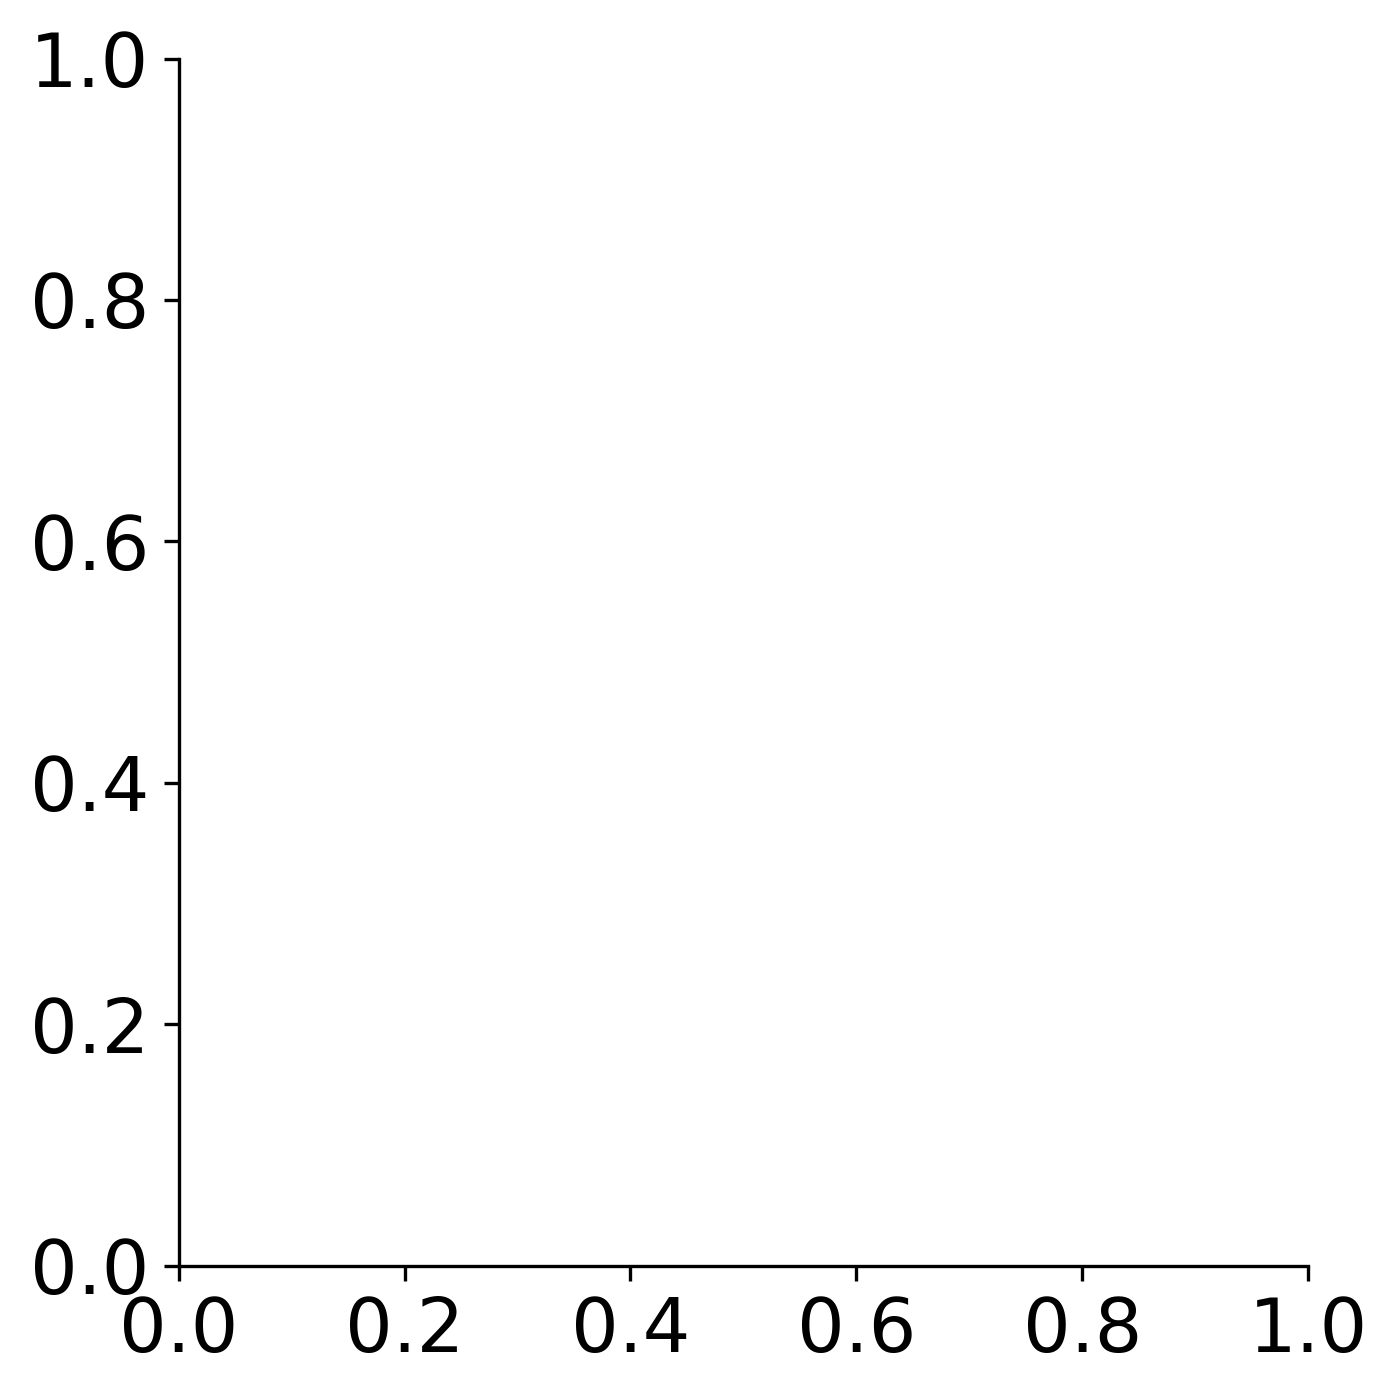

In [34]:
df = message_rtt_df

g = sns.catplot(
  data=df,
  x="send_time_sec",
  y="rtt_ms_first_transmission",
  hue="num_clients",
)

plt.show()

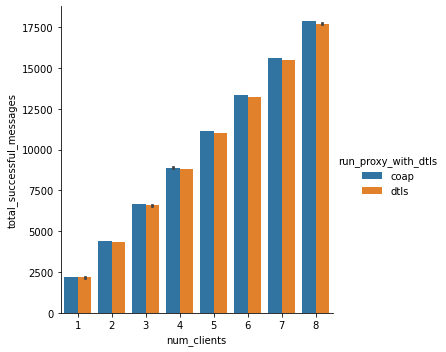

,exp_id,run_proxy_with_dtls,num_clients,trial,total_successful_messages
0,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,coap,1,1,2192
1,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,coap,1,2,2194
2,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,coap,1,3,2193
3,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,coap,1,4,2195
4,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,coap,1,5,2194
...,...,...,...,...,...
75,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,dtls,8,1,17706
76,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,dtls,8,2,17691
77,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,dtls,8,3,17682
78,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,dtls,8,4,17715


In [ ]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  x="num_clients",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  kind="bar",
)

plt.show()

df

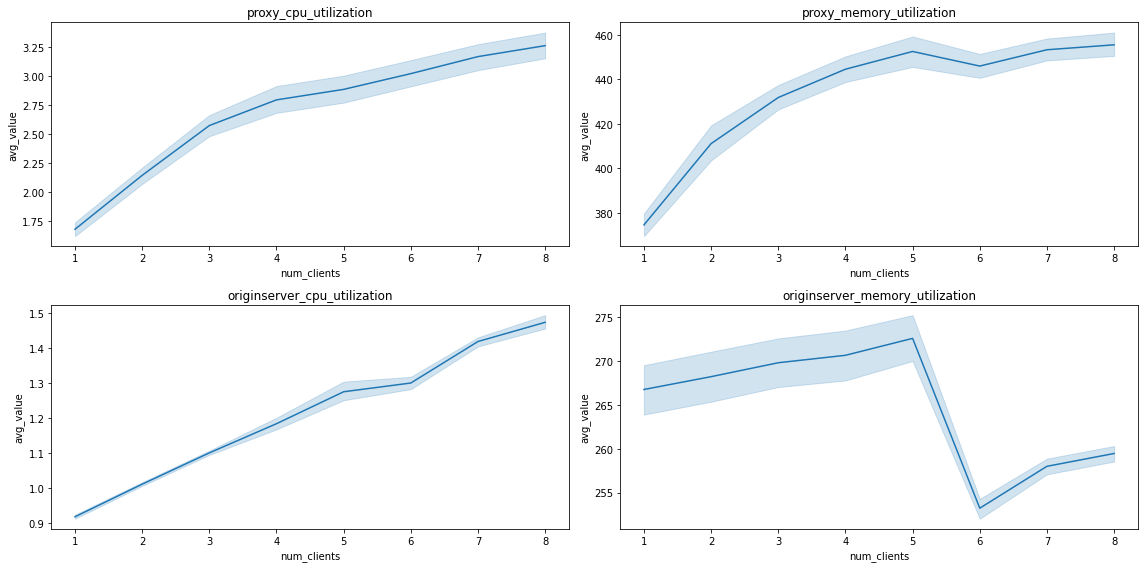

,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,0.935714,0.3,11.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
1,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,1.565000,0.5,21.2,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
2,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,261.662810,250.0,263.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
3,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,366.561983,251.0,404.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
4,thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,2,originserver,cpu_utilization,0.927143,0.3,10.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,4,proxy,memory_utilization,462.127273,245.0,495.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
316,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,originserver,cpu_utilization,1.485714,0.4,9.2,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
317,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,proxy,cpu_utilization,3.462143,0.5,26.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False
318,thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client,5,originserver,memory_utilization,260.966997,247.0,262.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,False


In [ ]:
df = metric_df

nodes = ["proxy", "originserver"]
metric_types = ["cpu_utilization", "memory_utilization"]
fig, ax = plt.subplots(len(metric_types), len(nodes))
for i, n in enumerate(nodes):
  for j, m in enumerate(metric_types):
    g = sns.lineplot(
      data=df[
        (df["observer_id"] == n)
        & (df["metric_type"] == m)
      ],
      x="num_clients",
      y="avg_value",
      ax=ax[i,j],
    )
    ax[i,j].set_title(f"{n}_{m}")

fig.tight_layout()
plt.show()

df

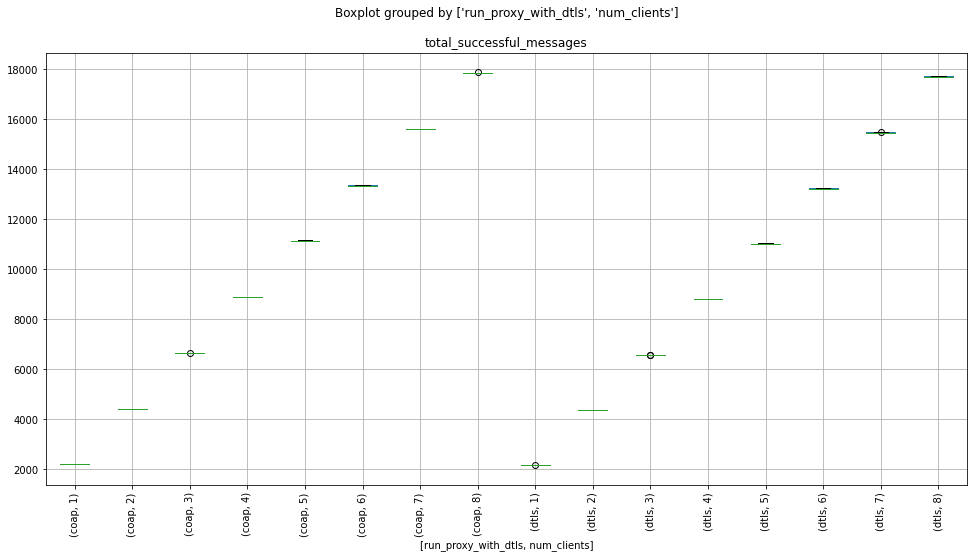

total_successful_messages
exp_id                                                                                               run_proxy_with_dtls num_clients trial                           
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client coap                1           1                           2192
                                                                                                                                     2                           2194
                                                                                                                                     3                           2193
                                                                                                                                     4                           2195
                                                                                                                                     5                           2194
...                                                                                                                                                               ...
thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client dtls                8           1                          17706
                                                                                                                                     2                          17691
                                                                                                                                     3                          17682
                                                                                                                                     4                          17715
                                                                                                                                     5                          17724

[80 rows x 1 columns]

In [ ]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
)
param_comparison_scope = ["run_proxy_with_dtls", "num_clients"]

plot_args = {
  "rot": 90,
  "by": param_comparison_scope,
}

df.boxplot("total_successful_messages", **plot_args)

plt.show()

df

In [43]:
### At this point, we generate figures for the paper

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

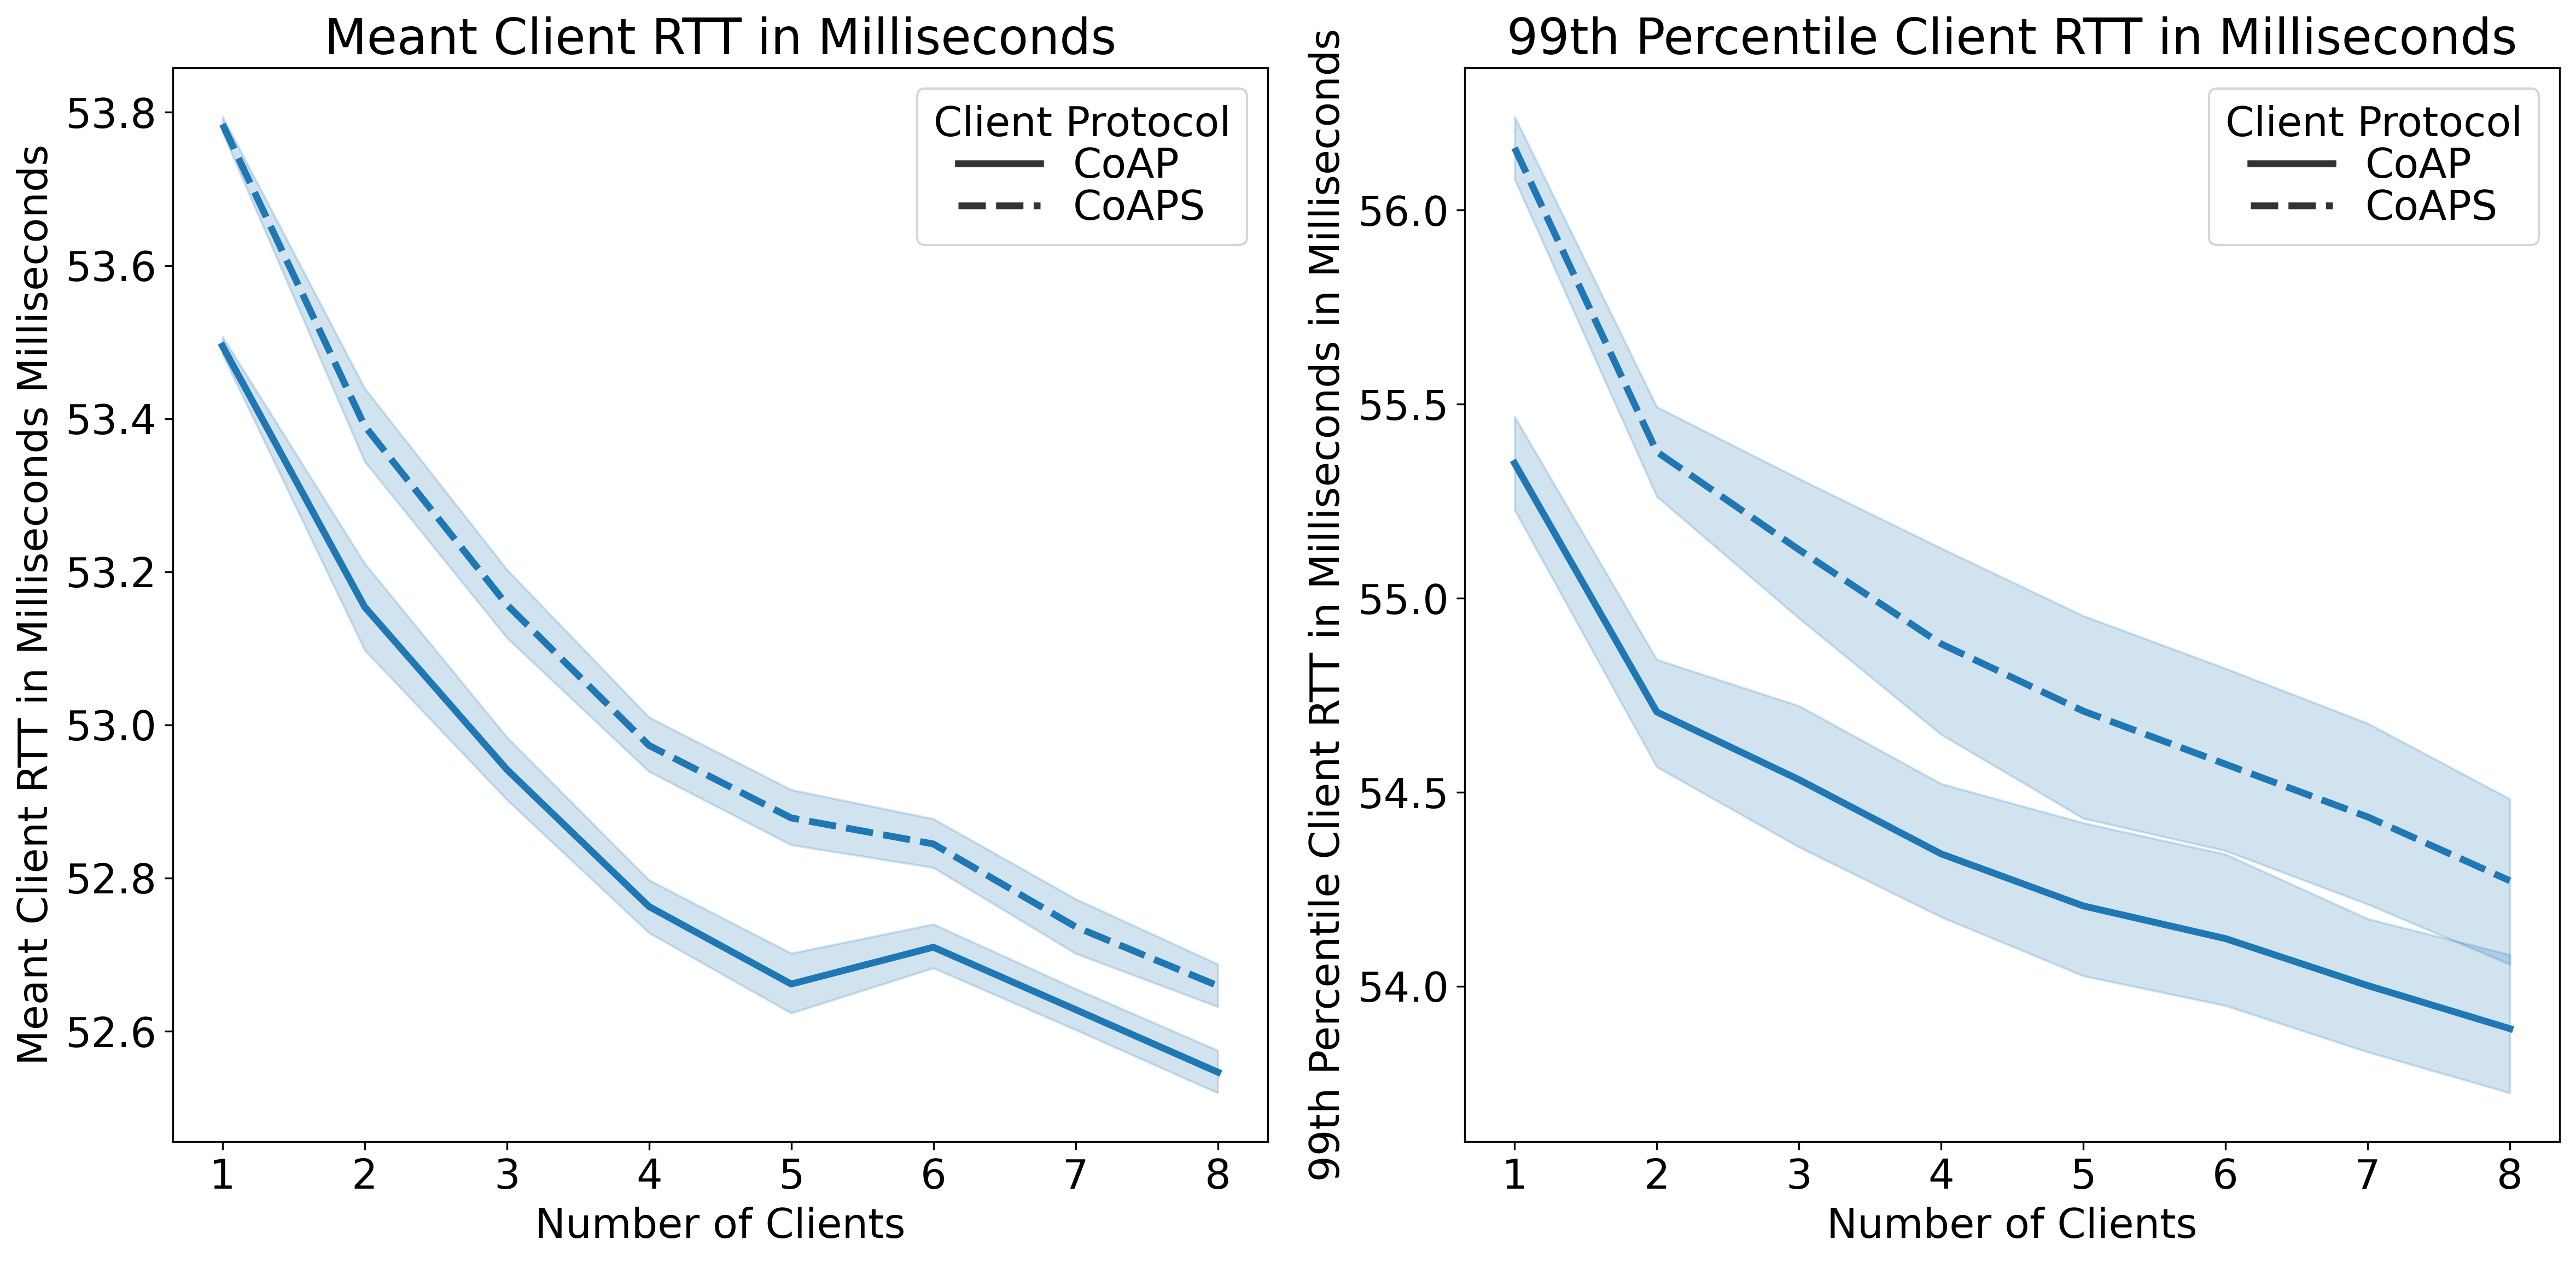

In [66]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

def get_properties(y):
  if y == "mean_rtt_ms":
    title = "Meant Client RTT in Milliseconds"
    ylabel = title + " Milliseconds"
  elif y == "rtt_ms_p99":
    title = "99th Percentile Client RTT in Milliseconds"
    ylabel = title + " in Milliseconds"
  else:
    raise Exception()
  
  return {
    "ylabel": ylabel,
    "title": title,
  }

ys = ["mean_rtt_ms", "rtt_ms_p99"]
fig, ax = plt.subplots(1, len(ys))
for i, y in enumerate(ys):
  g = sns.lineplot(
    data=df,
    x="num_clients",
    y=y,
    style="run_proxy_with_dtls",
    ax=ax[i]
  )

  sns.move_legend(
    g, 
    "upper right", 
    title="Client Protocol", 
    frameon=True, 
    labelspacing=0.05,
    bbox_to_anchor=((1, 1)),
    markerfirst=True,
  )

  props = get_properties(y)
  ax[i].set_xlabel("Number of Clients")
  ax[i].set_ylabel(props["ylabel"])
  ax[i].set_title(props["title"])

fig.tight_layout(pad=1)
plt.show()

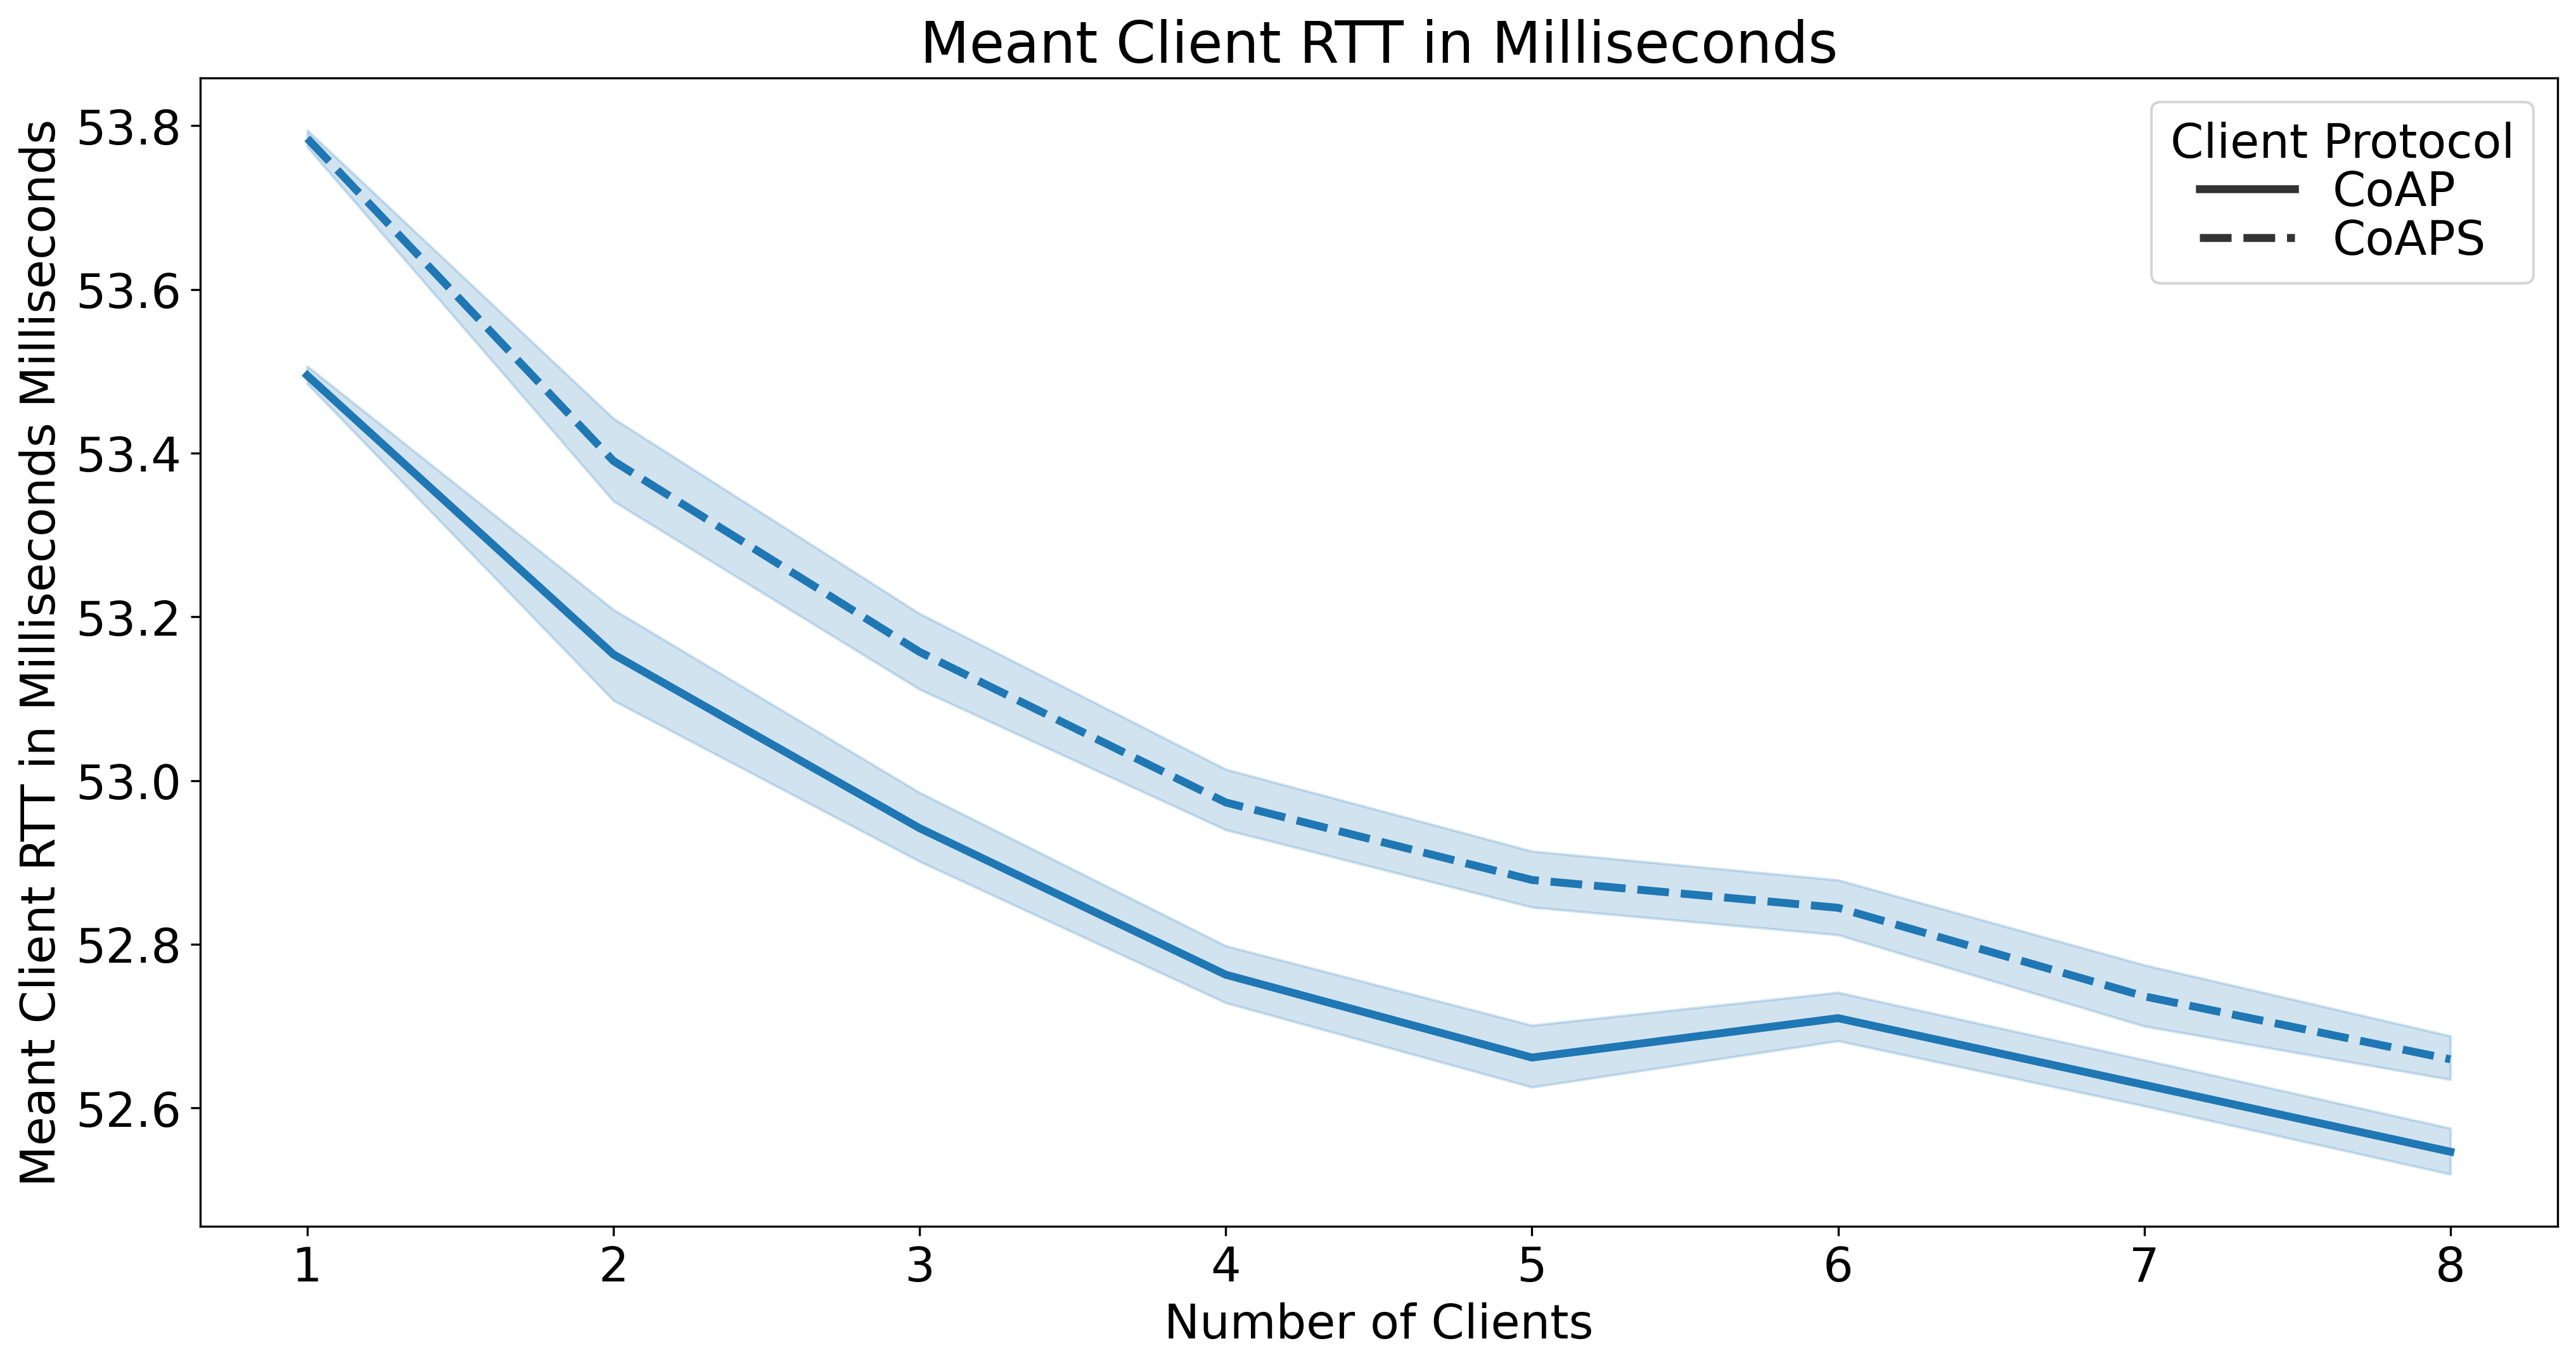

In [65]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

def get_properties(y):
  if y == "mean_rtt_ms":
    title = "Meant Client RTT in Milliseconds"
    ylabel = title + " Milliseconds"
  elif y == "rtt_ms_p99":
    title = "99th Percentile Client RTT in Milliseconds"
    ylabel = title + " in Milliseconds"
  else:
    raise Exception()
  
  return {
    "ylabel": ylabel,
    "title": title,
  }

g = sns.lineplot(
  data=df,
  x="num_clients",
  y="mean_rtt_ms",
  style="run_proxy_with_dtls"
)

sns.move_legend(
  g, 
  "upper right", 
  title="Client Protocol", 
  frameon=True, 
  labelspacing=0.05,
  bbox_to_anchor=((1, 1)),
  markerfirst=True,
)

props = get_properties(y)
g.set_xlabel("Number of Clients")
g.set_ylabel(props["ylabel"])
g.set_title(props["title"])

plt.show()

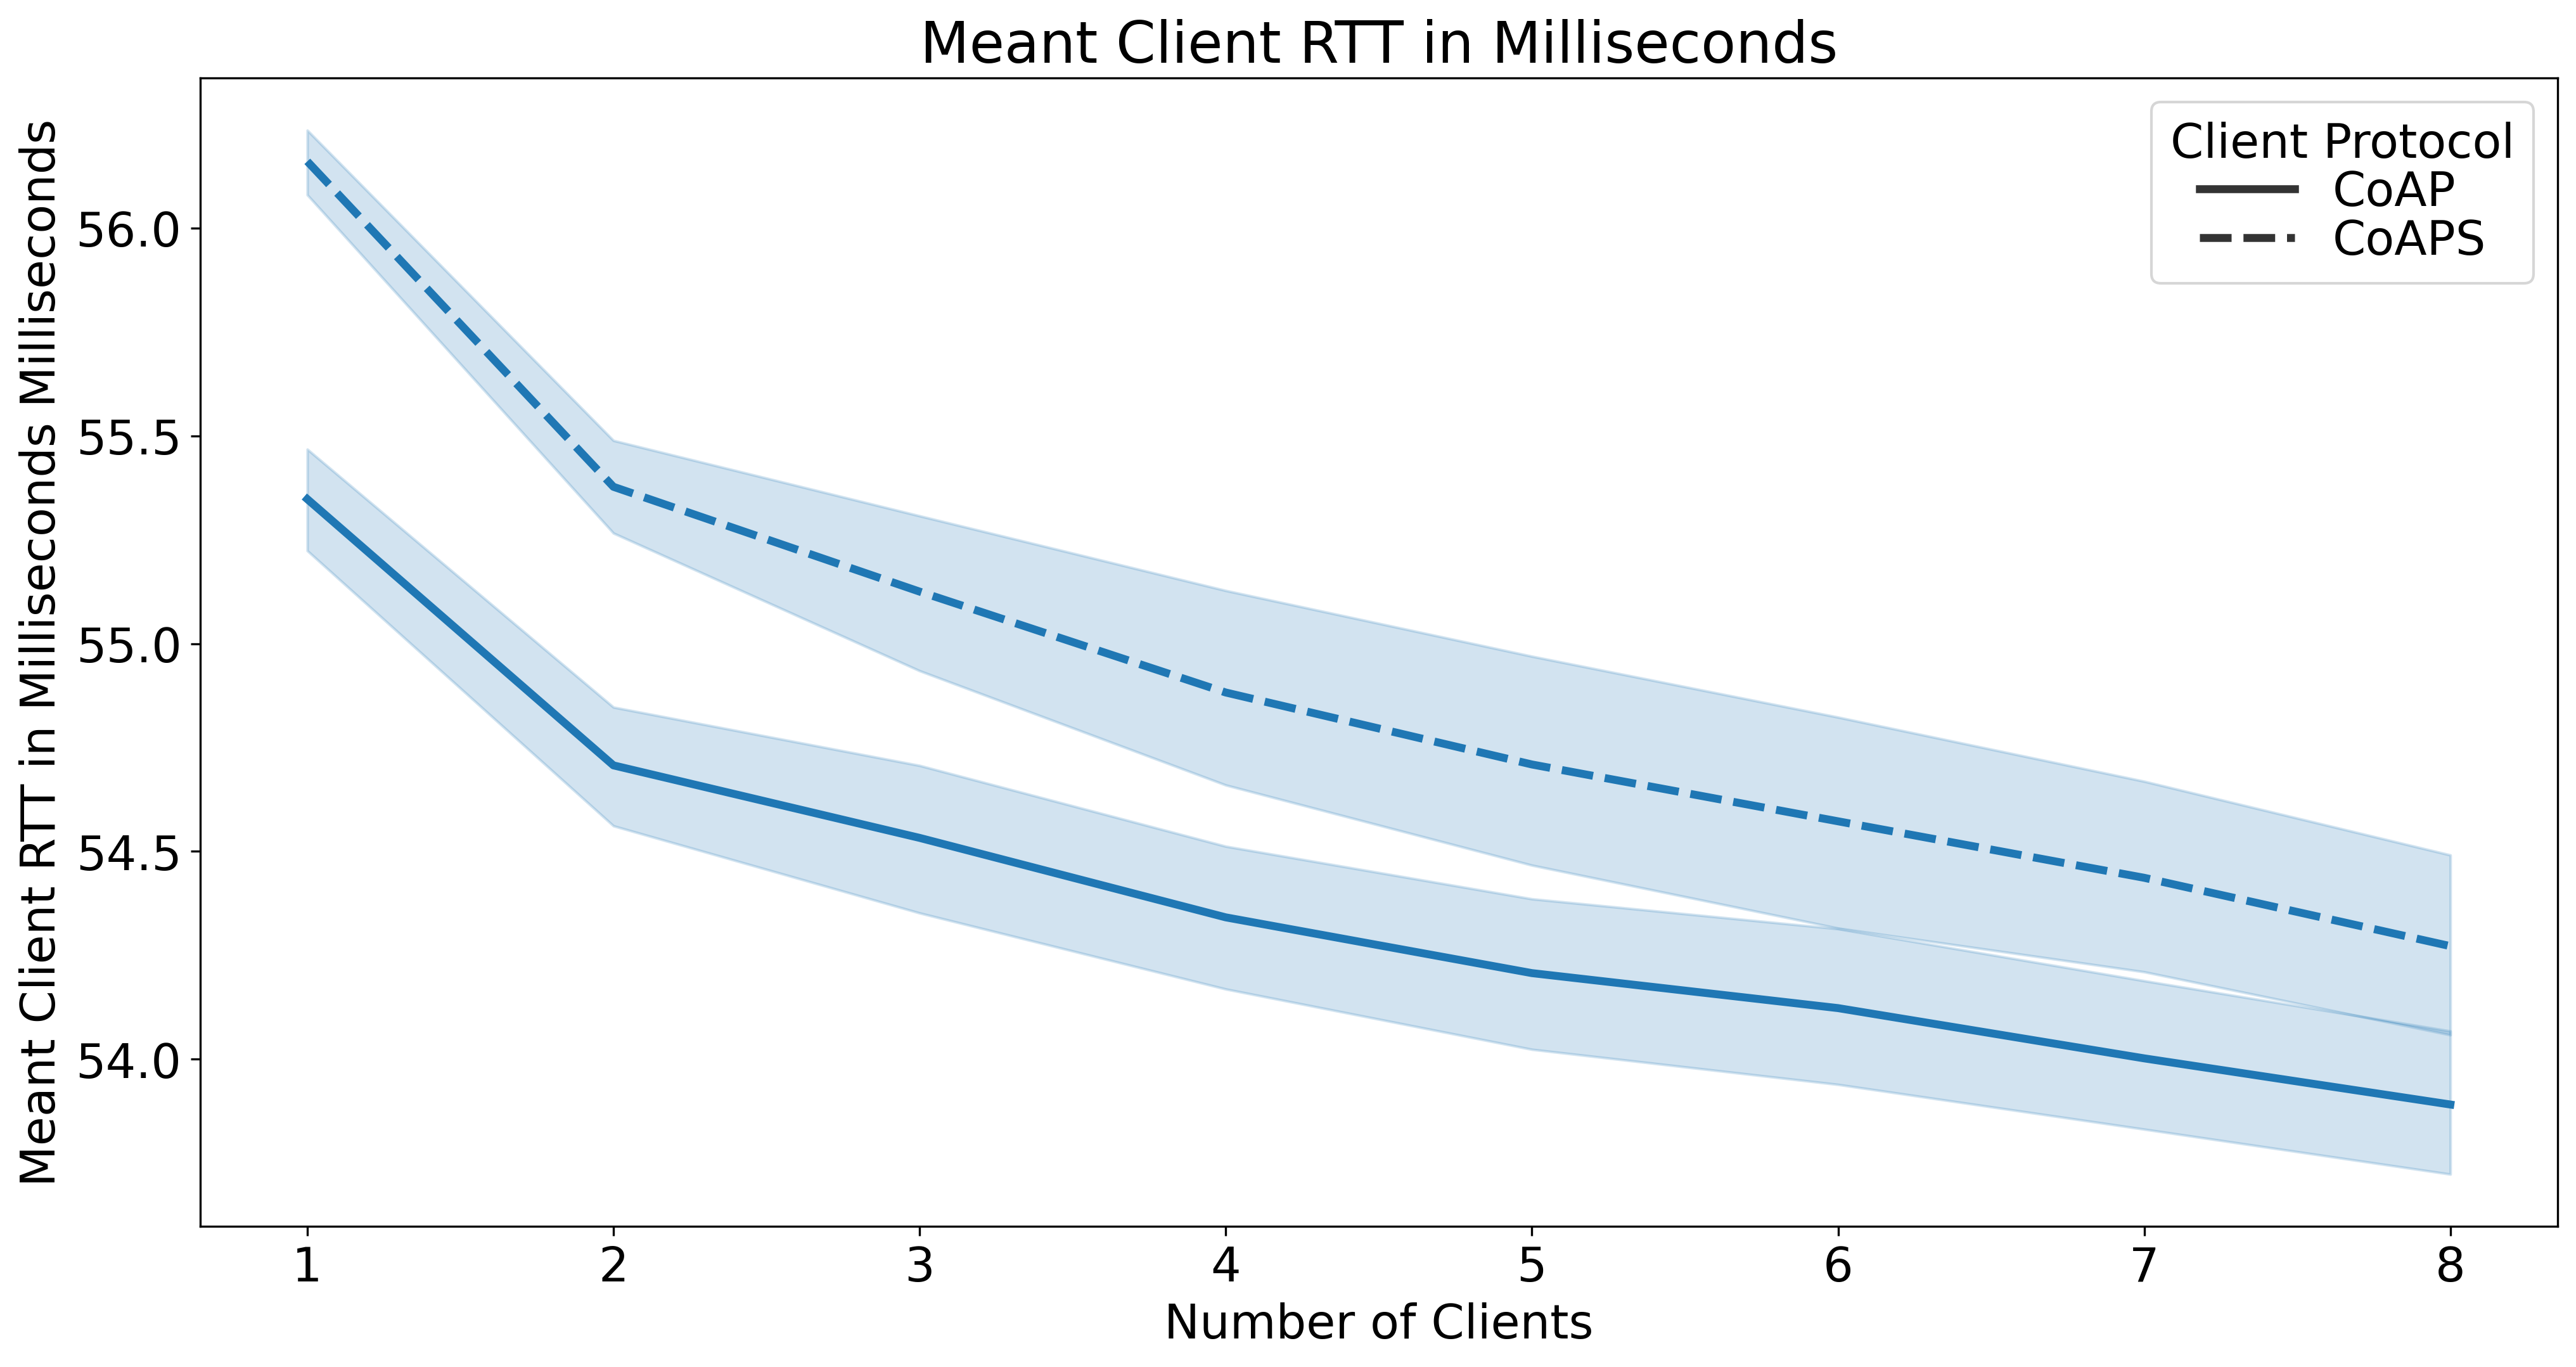

In [64]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

def get_properties(y):
  if y == "mean_rtt_ms":
    title = "Meant Client RTT in Milliseconds"
    ylabel = title + " Milliseconds"
  elif y == "rtt_ms_p99":
    title = "99th Percentile Client RTT in Milliseconds"
    ylabel = title + " in Milliseconds"
  else:
    raise Exception()
  
  return {
    "ylabel": ylabel,
    "title": title,
  }

g = sns.lineplot(
  data=df,
  x="num_clients",
  y="rtt_ms_p99",
  style="run_proxy_with_dtls"
)

sns.move_legend(
  g, 
  "upper right", 
  title="Client Protocol", 
  frameon=True, 
  labelspacing=0.05,
  bbox_to_anchor=((1, 1)),
  markerfirst=True,
)

props = get_properties(y)
g.set_xlabel("Number of Clients")
g.set_ylabel(props["ylabel"])
g.set_title(props["title"])

plt.show()